# RSMC Historical Forecasts

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [399]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from src.datasources import codab, rsmc

In [318]:
adm = codab.load_codab(aoi_only=True)

In [319]:
adm

,Shape_Leng,Shape_Area,ADM1_PT,ADM1_PCODE,ADM1_REF,ADM1ALT1PT,ADM1ALT2PT,ADM0_EN,ADM0_PT,ADM0_PCODE,date,validOn,validTo,geometry
2,17.581768,6.050592,Inhambane,MZ03,None,None,None,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,0000/00/00,"MULTIPOLYGON (((35.52187 -22.18423, 35.52104 -..."
6,20.547307,6.568407,Nampula,MZ07,None,None,None,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,0000/00/00,"MULTIPOLYGON (((39.79597 -16.35094, 39.79547 -..."
8,20.337796,5.815848,Sofala,MZ09,None,None,None,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,0000/00/00,"MULTIPOLYGON (((35.11009 -20.90418, 35.1104 -2..."
10,20.020215,8.731307,Zambezia,MZ11,None,None,None,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,0000/00/00,"MULTIPOLYGON (((36.32738 -18.80599, 36.32821 -..."


In [299]:
df = rsmc.load_historical_forecast_distances()
distance_cols = [x for x in df.columns if "_distance_km" in x]
df["any_distance_km"] = df[distance_cols].min(axis=1)

In [374]:
df["season"].unique()

array(['20102011', '20112012', '20122013', '20132014', '20142015',
       '20152016', '20162017', '20172018', '20182019', '20192020',
       '20202021', '20212022', '20222023', '20232024'], dtype=object)

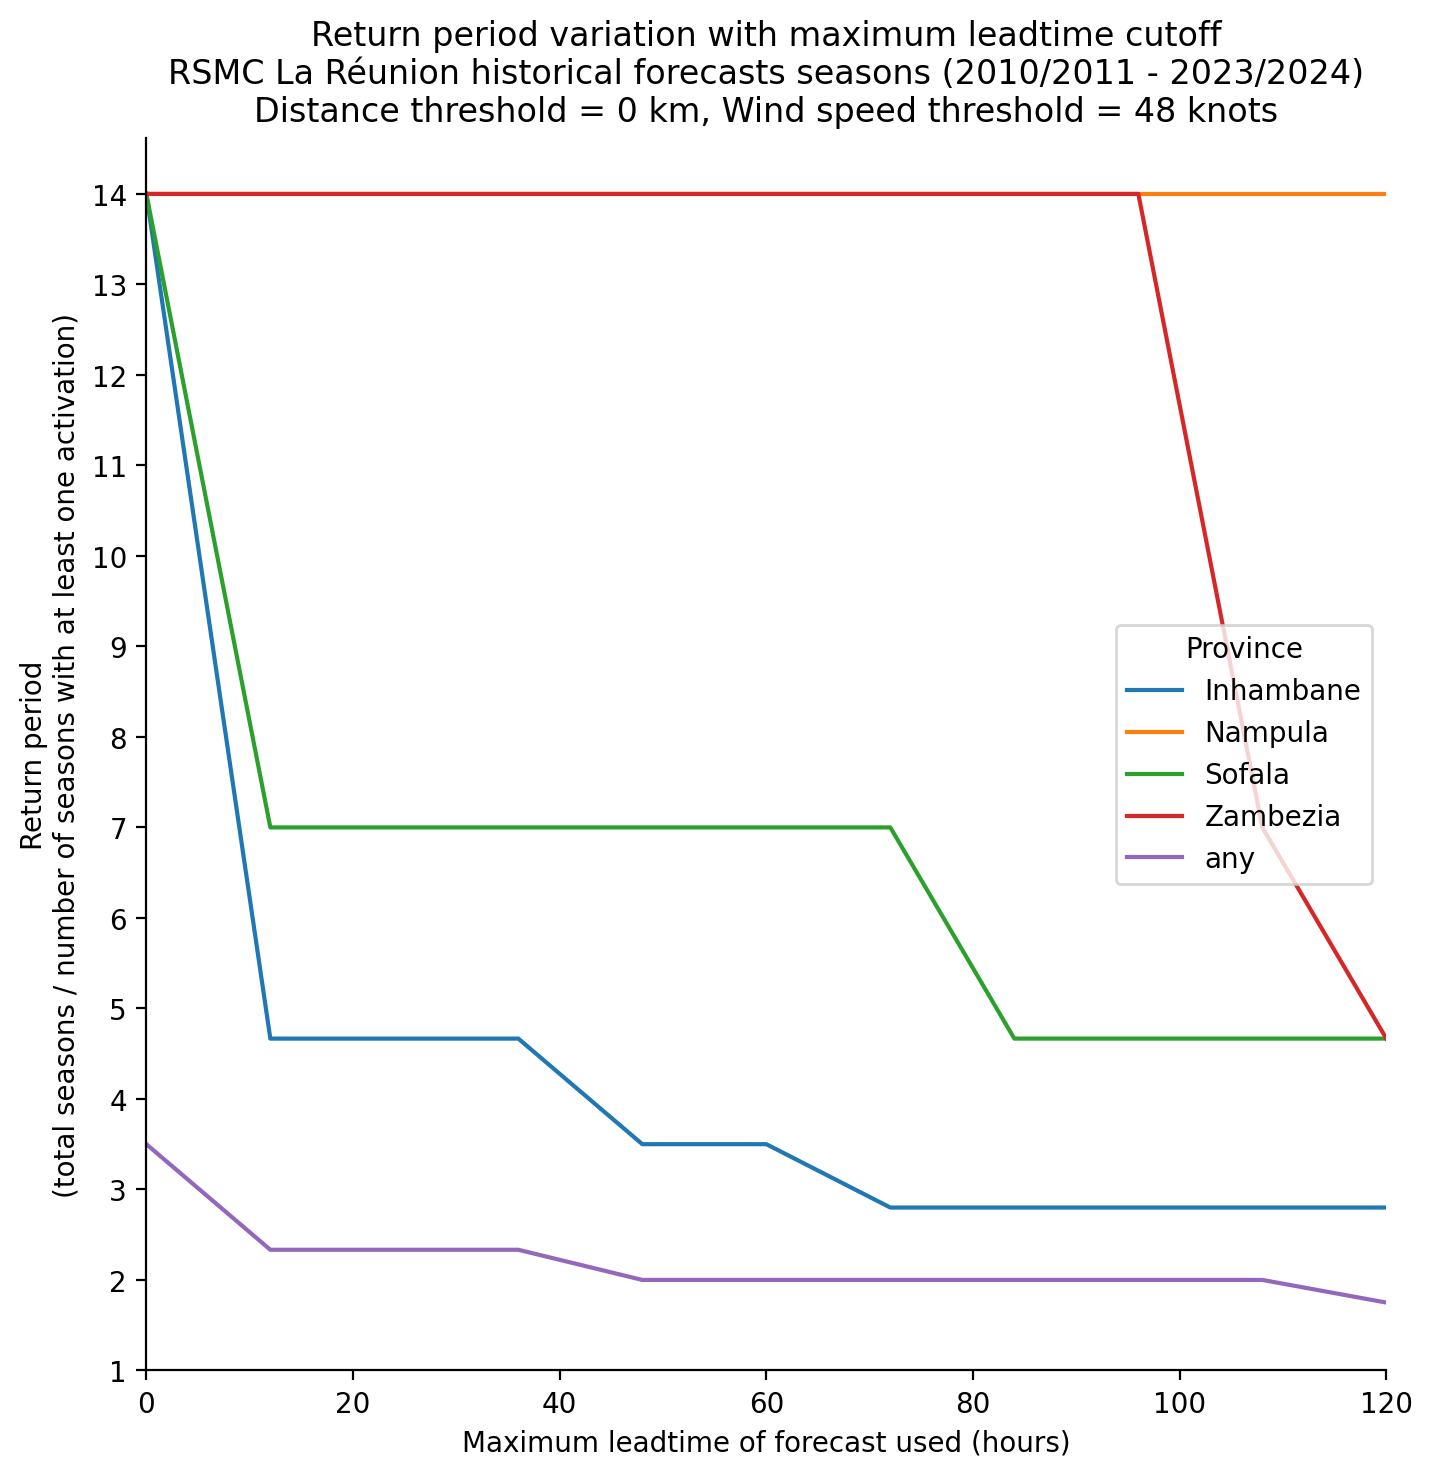

In [386]:
distance_thresh = 0
wind_thresh = 48

dicts = []
for max_lt in range(0, 121, 12):
    for pcode, row in adm.set_index("ADM1_PCODE").iterrows():
        rp = rsmc.calculate_rp(
            df,
            pcode=pcode,
            max_lt=max_lt,
            distance_thresh=distance_thresh,
            wind_thresh=wind_thresh,
        )
        dicts.append(
            {
                "ADM1_PCODE": pcode,
                "ADM1_PT": row["ADM1_PT"],
                "max_lt": max_lt,
                "rp": rp,
            }
        )
    rp = rsmc.calculate_rp(df, pcode="any", max_lt=max_lt)
    dicts.append(
        {"ADM1_PCODE": "any", "ADM1_PT": "any", "max_lt": max_lt, "rp": rp}
    )

df_rps = pd.DataFrame(dicts)

fig, ax = plt.subplots(dpi=200, figsize=(8, 8))
df_rps.pivot(columns="ADM1_PT", values="rp", index="max_lt").plot(ax=ax)
ax.set_title(
    "Return period variation with maximum leadtime cutoff\n"
    "RSMC La Réunion historical forecasts seasons (2010/2011 - 2023/2024)\n"
    f"Distance threshold = {distance_thresh} km, Wind speed threshold = {wind_thresh} knots"
)
ax.legend(title="Province")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0, right=120)
ax.set_yticks(range(1, 15))
ax.set_ylabel(
    "Return period\n"
    "(total seasons / number of seasons with at least one activation)"
)
ax.set_xlabel("Maximum leadtime of forecast used (hours)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

filename = (
    f"rsmc_forecasts_rp_dthresh{distance_thresh}_sthresh{wind_thresh}.csv"
)
df_rps.to_csv(rsmc.RSMC_PROC_DIR / filename, index=False)

In [418]:
distance_thresh = 0
wind_threshs = [48, 64, 90]

dicts = []
for max_lt in range(0, 121, 12):
    for wind_thresh in wind_threshs:
        rp = rsmc.calculate_rp(
            df,
            pcode="any",
            max_lt=max_lt,
            distance_thresh=distance_thresh,
            wind_thresh=wind_thresh,
        )
        dicts.append(
            {
                "wind_thresh": wind_thresh,
                "max_lt": max_lt,
                "rp": rp,
            }
        )
df_rps = pd.DataFrame(dicts)

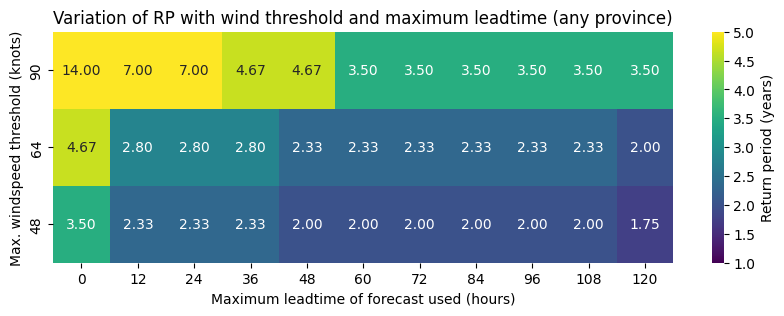

In [421]:
heatmap_data = df_rps.pivot(index="wind_thresh", columns="max_lt", values="rp")

fig, ax = plt.subplots(figsize=(10, 3))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    ax=ax,
    vmax=5,
    vmin=1,
    cmap="viridis",
    cbar_kws={"label": "Return period (years)"},
)

ax.set_xlabel("Maximum leadtime of forecast used (hours)")
ax.set_ylabel("Max. windspeed threshold (knots)")
ax.set_title(
    "Variation of RP with wind threshold and maximum leadtime (any province)"
)
ax.invert_yaxis()

plt.show()